In [1]:
from kaggle_environments import make, evaluate
import numpy as np
import matplotlib.pyplot as plt



Loading environment football failed: No module named 'gfootball'


In [2]:
def get_place_from_index(index, inp):
    for i in range(len(inp)):
        if len(inp[i][0]["observation"]["geese"][index]) == 0:
            survived = len(inp[i][0]["observation"]["geese"][index]) != 0
            others_survived = np.sum([len(x) != 0 for x in inp[i][0]["observation"]["geese"]]) - survived
            return others_survived

    survived = len(inp[-1][0]["observation"]["geese"][index]) != 0
    others_survived = np.sum([len(x) != 0 for x in inp[-1][0]["observation"]["geese"]]) - survived
    return others_survived

def evaluate_agents(agents, num_episodes=1000, debug=True):
    env = make("hungry_geese", debug=False)

    results = []

    for i in range(num_episodes):
        if debug:
            print(f"\rEvaluating: {i}/{100 * i/num_episodes:.2f}", end="")
        states = env.run(agents)

        results.append(get_place_from_index(0, states))
    return results

def evaluate_agent(agent, opponent, num_episodes=1000):
    result = evaluate_agents([agent, opponent, opponent, opponent], num_episodes, False)
    return np.mean(result), np.std(result)

def tournament(agents, num_episodes=50):
    point_estimate = np.zeros((len(agents), len(agents)))
    std_dev = np.zeros((len(agents), len(agents)))
    for i in reversed(range(len(agents))):
        for j in reversed(range(len(agents))):
            print(f"\r{i * len(agents) + j}/{100 - 100 * (i * len(agents) + j)/(len(agents)**2):.2f}, {agents[i]} vs {agents[j]}", end="")
            point_estimate[i][j], std_dev[i][j] = evaluate_agent(agents[i], agents[j], num_episodes)

    return point_estimate, std_dev

In [3]:

opponents = ["random", "greedy"]

env = make("hungry_geese", debug=False)
env.reset()
selfplay = ["main.py", "main.py", "main.py", "main.py"]
greedy = ["greedy", "main.py", "greedy", "greedy"]
randoms = ["better_random.py", "main.py", "better_random.py", "better_random.py"]
env.run(selfplay)
print(env.logs[3][0]["stderr"])
env.render(mode="ipython", width=1000, height=800)
#evaluate("hungry_geese", ["greedy", "random", "greedy", "greedy"], {}, [], 100)


In [6]:
tournament_agents = ["better_random.py", "greedy", "tournament/A1/main.py", "tournament/A2/main.py", "tournament/A3/main.py", "tournament/A4/main.py", "tournament/A5/main.py", "tournament/A5TW/main.py"]
tournament_labels = ["better_random.py", "greedy", "A1", "A2", "A3", "A4", "A5", "A5TW"]
point_estimate, std_dev = tournament(tournament_agents, num_episodes=50)


<ipython-input-5-a4f91227c9d8>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+tournament_labels)
<ipython-input-5-a4f91227c9d8>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+tournament_labels)


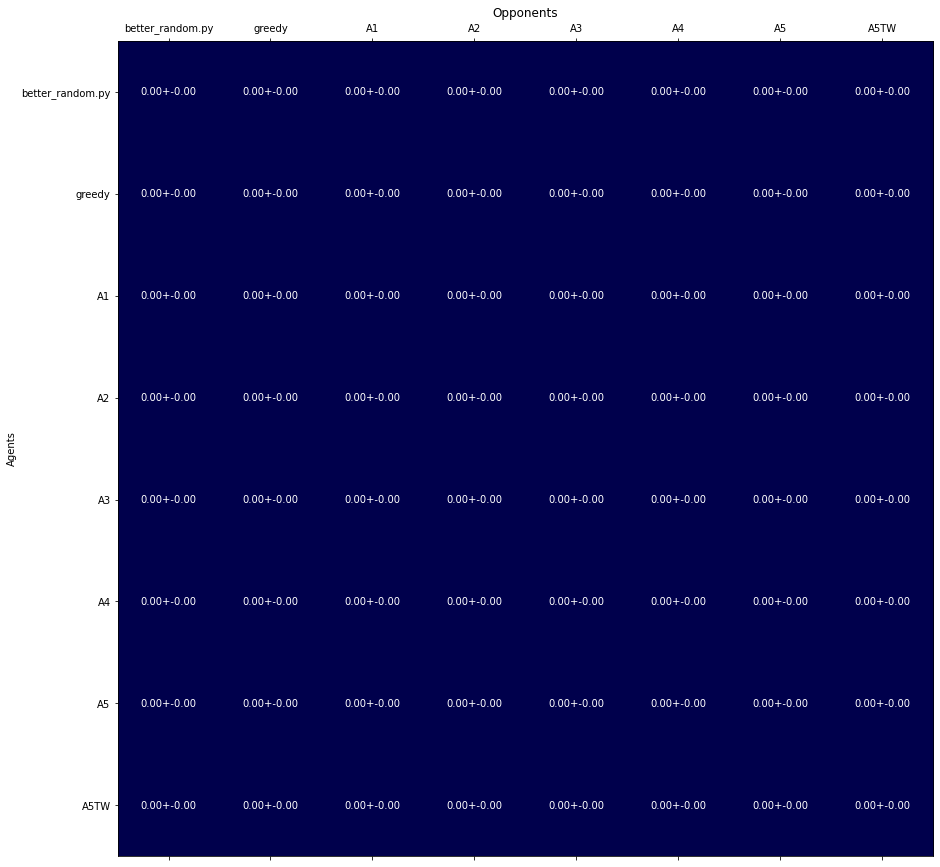

In [5]:
fig, ax = plt.subplots(figsize=(15, 15))
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(point_estimate, cmap='seismic', vmin=0, vmax=4)
ax.set_yticklabels(['']+tournament_labels)
ax.set_xticklabels(['']+tournament_labels)

ax.set_title("Opponents")
ax.set_ylabel("Agents")

for (i, j), z in np.ndenumerate(point_estimate):
    ax.text(j, i, f"{point_estimate[i][j]:.2f}+-{1.96 * std_dev[i][j]:.2f}", color="black" if abs(point_estimate[i][j] - 2) < 0.5 else "white", ha='center', va='center')

plt.show()


In [6]:
import main

main.agent

import better_random
better_random.agent(None, None)

'NORTH'

In [7]:
from kaggle_environments import make
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np

env = make("hungry_geese", debug=False)

trainer = env.train([None, "greedy", "greedy", "greedy"])
possible_moves = [Action.NORTH.name, Action.EAST.name, Action.SOUTH.name, Action.WEST.name]

obs = []
observation = trainer.reset()
obs.append(observation)

done = False
while not done:
    action = np.random.choice(possible_moves)
    
    observation, reward, done, info = trainer.step(action)
    obs.append(observation)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

from DQN.model import Model
from shared.memory_manager import MemoryManager
from kaggle_environments.envs.hungry_geese.hungry_geese import Configuration
from kaggle_environments.envs.hungry_geese.hungry_geese import row_col

from shared.map import Map


memory_manager = MemoryManager(-1, 0.99)
memory_manager.add_memory([obs[-3], 1, 1, 1, 3, 0, obs[-2]], 1)

model = Model()
model.set_config(Configuration({"columns": 11, "rows": 7}))

trans_obs = memory_manager.last_episode[0][0]
map = Map(trans_obs, 11)
data = map.build_opponent_map(1).reshape(7,11)
data = map.build_opponent_map(0).reshape(7,11)

original = np.zeros(77)
original[map.player_head] = 5
for i in range(4):
    if i != trans_obs["index"]:
        if len(trans_obs["geese"][i]) != 0:
            original[trans_obs["geese"][i][0]] = i
            
            for j in range(1, len(map.geese[i])):
                original[trans_obs["geese"][i][j]] = i - 0.5



data = original.reshape(7,11)

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(data, cmap='seismic')

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()

transformed = np.zeros(77)
transformed[map.geese[map.player_index][0]] = 5
for i in range(4):
    if i != trans_obs["index"]:
        if len(map.geese[i]) != 0:
            transformed[map.geese[i][0]] = i
        
            for j in range(1, len(map.geese[i])):
                transformed[map.geese[i][j]] = i - 0.5


transformed = np.zeros(77)
data = transformed.reshape(7,11)

data[map.translate(map.player_head)] = 5
print("Head", map.player_head, map.translate(map.player_head))
for i in range(4):
    if i != trans_obs["index"]:
        if len(trans_obs["geese"][i]) != 0:
            data[map.translate(trans_obs["geese"][i][0])] = i
            print("translated", trans_obs["geese"][i][0], map.translate(trans_obs["geese"][i][0]))
            
            for j in range(1, len(map.geese[i])):
                data[map.translate(trans_obs["geese"][i][j])] = i - 0.5
                print("translated", trans_obs["geese"][i][0], map.translate(trans_obs["geese"][i][j]))



fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(data, cmap='seismic')

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()


print(trans_obs)


TypeError: add_memory() missing 1 required positional argument: 'mc_reward'